In [1]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/avic/OOD_Orientation_Generalization')
from my_dataclasses import *
from train.dataset import *
from train.train import *
import tools
import seaborn as sns
from pandas.api.types import CategoricalDtype
import itertools
import functools
from sklearn.preprocessing import normalize
from matplotlib_venn import *

In [48]:
def get_unrestricted_axis(restricted_axes):
    if restricted_axes[1] == '1':
        return 0
    if restricted_axes[4] == '1':
        return 2
    return 1

BASE_PATH = '/home/avic/OOD_Orientation_Generalization'

def get_exps_frame(exp_iter):
    exps_frame = pd.read_csv(os.path.join(BASE_PATH, f'exps{exp_iter}.csv'), index_col=[5,2])
    exps_frame = exps_frame[exps_frame.model_type == 'ModelType.ResNet']
    exps_frame = exps_frame[exps_frame.hole == 0]
    exps_frame = exps_frame[~exps_frame.pretrained & ~exps_frame.scale]
    exps_frame = exps_frame[~(exps_frame.training_category == 'lamp')]
    exps_frame['run'] = exp_iter
    exps_frame['pred_model_i'] = exps_frame.restriction_axes.apply(get_unrestricted_axis) + exps_frame.hole
    
    fits = pd.read_csv(os.path.join(BASE_PATH, f'fits2/exp{exp_iter}_fits.csv')).reset_index()
    
    joined_subset = exps_frame.merge(fits, on=['num', 'data_div'])
    return joined_subset

In [49]:
exps_frames = pd.concat([get_exps_frame(exp_iter) for exp_iter in range(1, 4)]).reset_index()

In [4]:
def sig(arr, x, y):
    return np.divide(1, 1 + np.exp(((-arr) + x) * y))

def argsig(arr, p, x, y):
    return sig(np.power(arr, (p + 1) * 5), (x / 10), y)

def fitted_model(arr, exp):
    return np.maximum(argsig(arr[0], exp.AE_fit_arg0, exp.AE_fit_arg1, exp.AE_fit_arg2), argsig(arr[1], exp.AE_fit_arg3, exp.AE_fit_arg4, exp.AE_fit_arg5))

pred_models = tools.get_all_generated_canonical_heatmaps()[:3]

In [67]:
exps_frames[:12].restriction_axes

0     (0, 1)
1     (0, 1)
2     (0, 1)
3     (0, 1)
4     (1, 2)
5     (1, 2)
6     (1, 2)
7     (1, 2)
8     (0, 2)
9     (0, 2)
10    (0, 2)
11    (0, 2)
Name: restriction_axes, dtype: object

/home/avic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


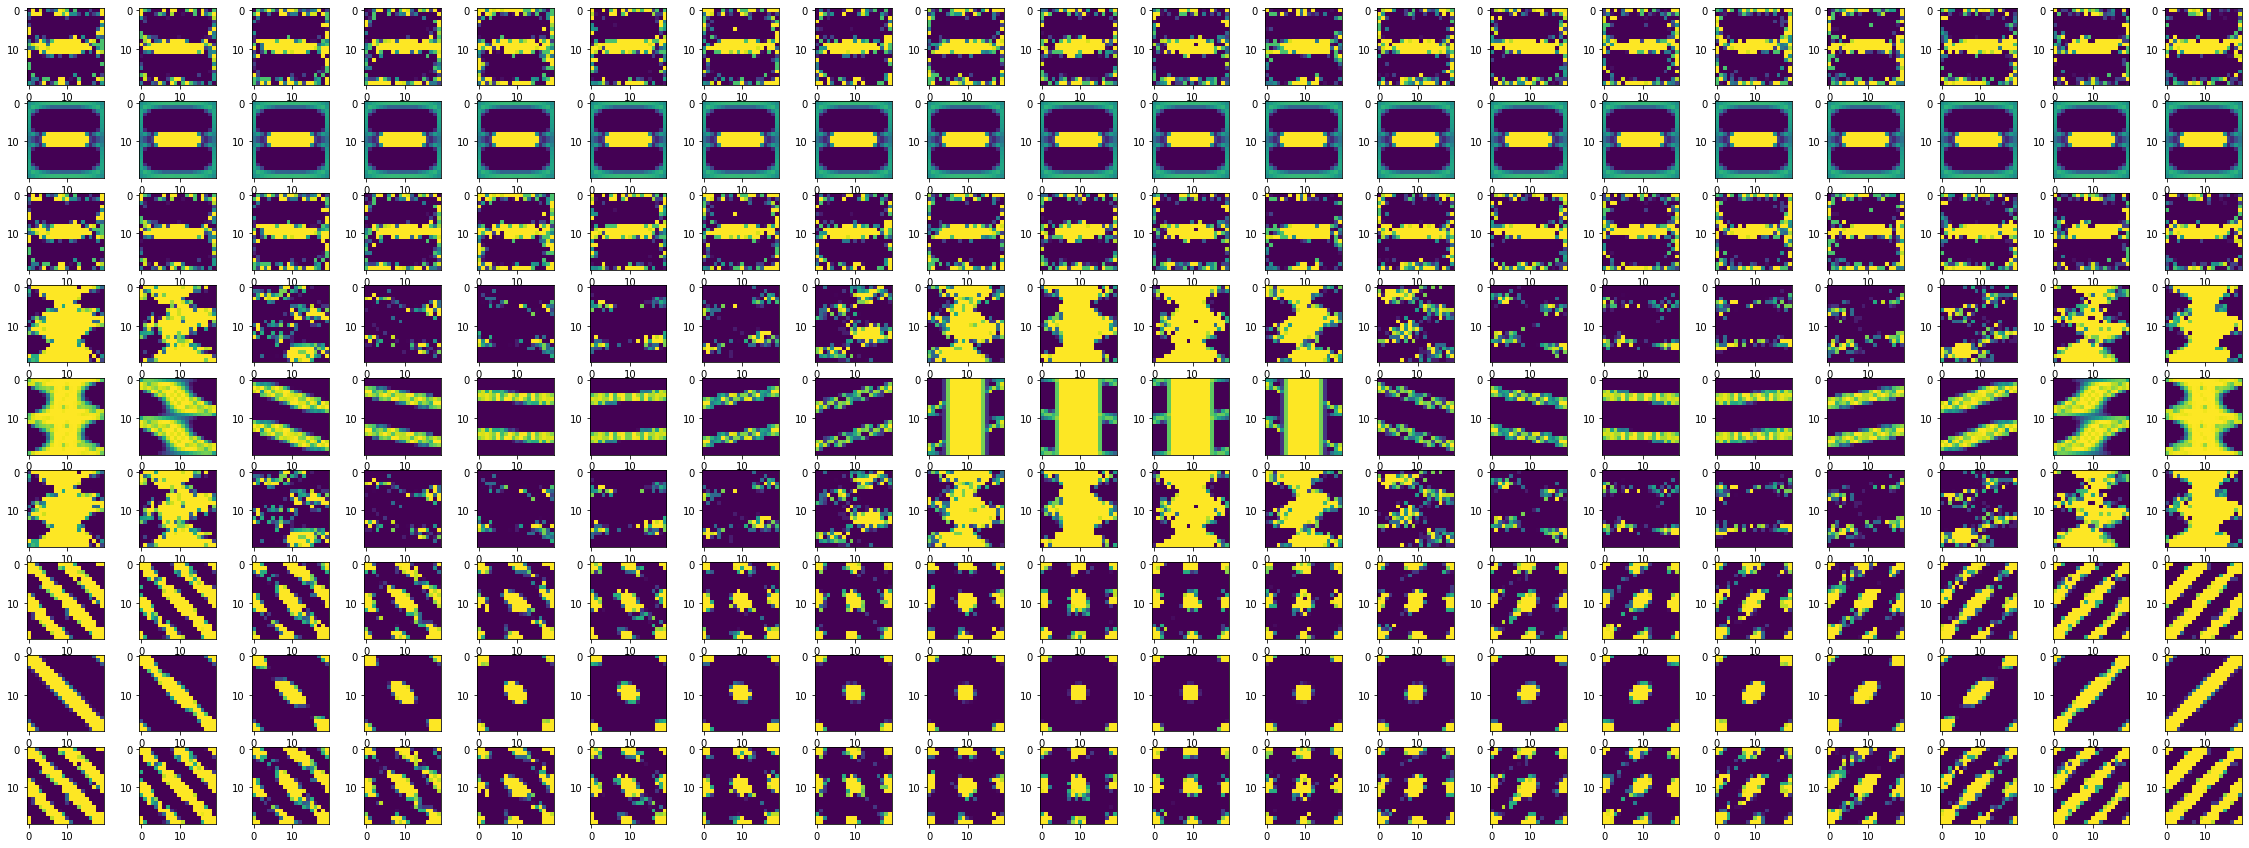

In [85]:
# exp = exps_frames[exps_frames.job_id == 31].iloc[0]#exps_frames.iloc[15]

# heatmap = np.load(exp.eval_heatmap)
# fitted = fitted_model(pred_models[exp.pred_model_i], exp)

plt.close('all')

THRESH = 0.7

exps = exps_frames[:12][exps_frames.data_div == 40]
_, axes = plt.subplots(9, 20, figsize=(40, 15))
for x in range(3):
    exp = exps.iloc[x]
    h = np.nan_to_num(np.load(exp.eval_heatmap))
    h = (h - np.mean(h)) / np.std(h)
    # m = pred_models[exp.pred_model_i][0]#
    # d = pred_models[exp.pred_model_i][1]#
    m = fitted_model(pred_models[exp.pred_model_i], exp)
    m = (m - np.mean(m)) / np.std(m)
    # m = np.load(exps.iloc[x + 1].eval_heatmap)
    for y in range(20):
        
        a = [2, 0, 1][x]
        if a == 0:
            hp = h[y]
            mp = m[y]
        if a == 1:
            hp = h[:, y]
            mp = m[:, y]
        else:
            hp = h[..., y]
            mp = m[..., y]
            # hpd = d[..., y]

        hpd = hp.copy()
        # hpd[mp] = 0
        
        axes[(x * 3), y].imshow(hp, norm=plt.Normalize(vmin=0, vmax=1))
        axes[(x * 3) + 1, y].imshow(mp, norm=plt.Normalize(vmin=0, vmax=1))
        axes[(x * 3) + 2, y].imshow(hpd, norm=plt.Normalize(vmin=0, vmax=1))
        # axes[1,x].imshow(fitted[..., x])
        # axes[2,x].imshow(fitted[..., x] > 0.8, norm=plt.Normalize(vmin=0, vmax=1))

In [6]:
r = range(1, 100, 2)
scores = np.zeros((3, 4, 2, len(r)))
thresholds = np.array(r) / 100

for i, (_, group) in enumerate(exps_frames[:12].groupby('num')):
    # fitted = np.load(group.iloc[-1].eval_heatmap)
    fitted = fitted_model(pred_models[group.iloc[-1].pred_model_i], group.iloc[-1])
    masks = (np.expand_dims(fitted.flatten(), axis=0) > np.expand_dims(thresholds, axis=1))
    for j, exp in enumerate(group.itertuples()):
        heatmap = np.load(exp.eval_heatmap)
        scores[i, j, 0] = np.nansum(masks * heatmap.flatten()[np.newaxis, :], axis=1) / np.sum(masks, axis=1)
        scores[i, j, 1] = np.nansum(~masks * heatmap.flatten()[np.newaxis, :], axis=1) / np.sum(~masks, axis=1)        

AttributeError: 'Series' object has no attribute 'AE_fit_arg0'

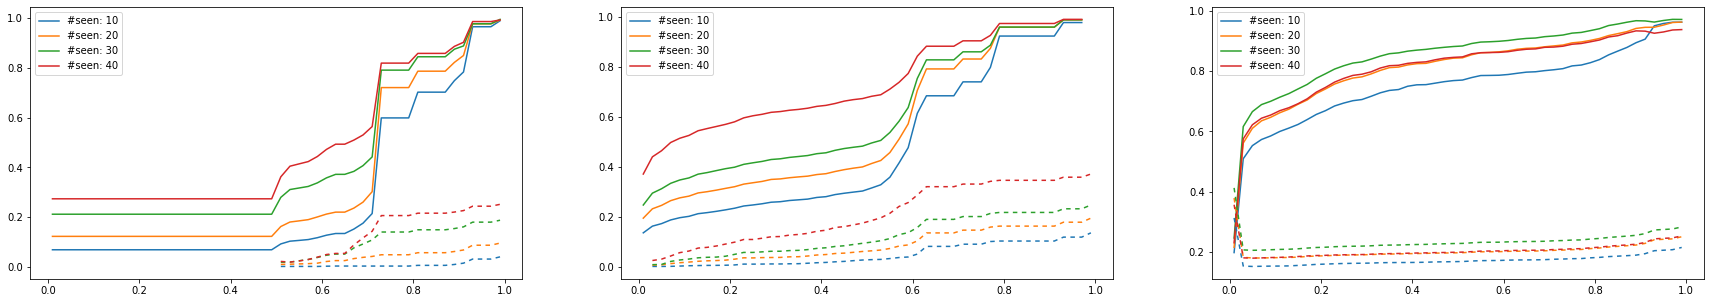

In [15]:
plt.close('all')
fig, axes = plt.subplots(1, 3, figsize=(30, 5))
for x in range(3):
    axes[x].plot(thresholds, scores[x, :, 0].T)
    axes[x].set_prop_cycle(None)
    axes[x].plot(thresholds, scores[x, :, 1].T, dashes=(3, 3))
    axes[x].legend([f'#seen: {(x + 1) * 10}' for x in range(4)], loc='upper left')

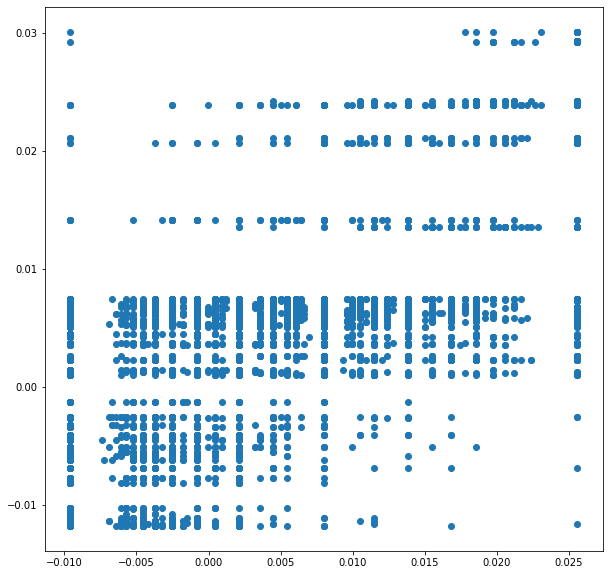

In [13]:
exp = exps_frames.iloc[3]
heatmap = np.nan_to_num(np.load(exp.eval_heatmap))
fitted = fitted_model(pred_models[exp.pred_model_i], exp)

def normalized(arr):
    return arr / np.sqrt(np.sum(np.power(arr, 2)))

plt.subplots(1, 1, figsize=(10, 10))
plt.scatter(normalized(n_heatmap.flatten()), normalized(n_fitted.flatten()))

In [24]:
xs, ys, zs = tools.get_heatmap_cell_ranges2(20)

cubelet_ranges = np.array(list(itertools.product(*[np.stack([vs[:-1], vs[1:]]).T for vs in [xs, ys, zs]]))).reshape(20, 20, 20, 3, 2)
# pred_models_mask_ranges = [cubelet_ranges[pred_models_mask[x]] for x in range(3)]

bin_ranges = np.array(
    [[[-5, 5],
      [-0.25, 0.25],
      [-0.25, 0.25]],
     [[-0.25, 0.25],
      [-5, 5],
      [-0.25, 0.25]],
     [[-0.25, 0.25],
      [-0.25, 0.25],
      [-5, 5]]])

In [65]:
cubelet_ranges

(20, 20, 20, 3, 2)

In [82]:
# exp = exps_frames.iloc[3]
# exp_dataclass = ExpData.get_experiments(exp.job_id)

# image_activations = np.load(exp_dataclass.image_activations)

# rd = RotationDataset(exp_dataclass)
# df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
# df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes

# bin_range = bin_ranges[e.pred_model_i]
# augment_model_mask = np.load(exps_frames[exps_frames.job_id == (((e.job_id // 8) + 1) * 8) - 1].iloc[0].eval_heatmap) > 0.7
# pred_model_ranges = cubelet_ranges[~augment_model_mask]

# pred_models_mask_ranges[e.pred_model_i]

df['in_bin'] = df.object_x.between(*bin_range[0]) & df.object_y.between(*bin_range[1]) & df.object_z.between(*bin_range[2])
df['in_hole'] = functools.reduce(lambda a, b: a | df.object_x.between(*b[0]) & df.object_y.between(*b[1]) & df.object_z.between(*b[2]), pred_model_ranges, True)
df['in_fig8'] = ~df.in_bin & ~df.in_hole

df['paradigm_type'] = df.model_name.isin(rd.training_models).apply(lambda x: ['testing', 'training'][x])
df['pattern'] = (df.in_bin + (df.in_hole * 2) + (df.in_fig8 * 3)).apply(lambda x: ['none', 'bin', 'hole', 'fig8'][x])

norm_image_activations = image_activations / np.max(image_activations, axis=0)

THRESHOLD = 0.2

pre_transformed_activations = np.zeros((50, 512))
for name, group in df[df.in_bin].groupby('model_name'):
    pre_transformed_activations[group.model_code.iloc[0]] = np.mean(norm_image_activations[group.index], axis=0)

pre_transformed_activations_per_image = pre_transformed_activations[df.model_code]

image_invariances = 1 - np.abs((norm_image_activations - pre_transformed_activations_per_image) / (norm_image_activations + pre_transformed_activations_per_image))

image_invariances_thresholded = np.where((norm_image_activations > THRESHOLD) | (pre_transformed_activations_per_image > THRESHOLD), image_invariances, np.nan)

/home/avic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


In [94]:
df[~df.in_hole & ~df.in_fig8]

,Unnamed: 0,image_name,model_name,object_x,object_y,object_z,model_code,in_bin,in_hole,in_fig8,paradigm_type,pattern


In [83]:
df[df.paradigm_type == 'testing'].groupby(['pattern']).mean('invariance')

,Unnamed: 0,object_x,object_y,object_z,model_code,in_bin,in_hole,in_fig8
pattern,,,,,,,,
fig8,2546.099,0.004266,-0.000818,0.071369,44.425000,1.0,1.0,0.0
hole,2498.549,0.005723,0.005839,-0.001050,44.501531,0.0,1.0,0.0


In [77]:
df.groupby(['paradigm_type', 'pattern']).apply(lambda group: pd.DataFrame({'invariance':np.nanmean(image_invariances_thresholded[group.index], axis=0)})).reset_index().rename({'level_2': 'neuron'}, axis=1)

,paradigm_type,pattern,neuron,invariance
0,testing,fig8,0,0.842940
1,testing,fig8,1,0.767717
2,testing,fig8,2,0.845571
3,testing,fig8,3,0.883424
4,testing,fig8,4,0.928582
...,...,...,...,...
2043,training,hole,507,0.734647
2044,training,hole,508,0.687252
2045,training,hole,509,0.598669
2046,training,hole,510,0.764451


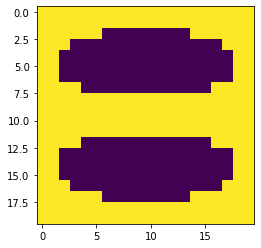

In [15]:
analytical_heatmap = np.load('canonical_z_unrestricted_heatmap.npy')

fig8 = np.mean((np.power(analytical_heatmap[0], 10) * 3) + (np.power(analytical_heatmap[1], 20) * 1), axis=2) > 0.5
# plt.close('all')
# plt.imshow(np.mean(np.power(analytical_heatmap[0], 10) * 3, axis=2), norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
# plt.imshow(np.mean(np.power(analytical_heatmap[1], 20) * 1, axis=2), norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
# plt.imshow(fig8, norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
plt.imshow(fig8)

xs, ys, zs = tools.get_heatmap_cell_ranges2(20)

cubelet_ranges = np.array(list(itertools.product(np.stack([xs[:-1], xs[1:]]).T, np.stack([ys[:-1], ys[1:]]).T))).reshape(20, 20, 2, 2)

fig8_ranges = cubelet_ranges[~fig8]

In [16]:
violin_data = None
corr_data = None
for x in range(4):
    e = ExpData.get_experiments(x)

    image_activations = np.load(e.image_activations)

    rd = RotationDataset(e)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes

    in_bin = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
    df['in_bin'] = in_bin
    in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
    in_fig8 = ~in_bin & ~in_hole

    df['paradigm_type'] = df.model_name.isin(rd.training_models).apply(lambda x: ['testing', 'training'][x])
    df['pattern'] = (in_bin + (in_hole * 2) + (in_fig8 * 3)).apply(lambda x: ['none', 'bin', 'hole', 'fig8'][x])

    norm_image_activations = image_activations / np.max(image_activations, axis=0)

    THRESHOLD = 0.2

    pre_transformed_activations = np.zeros((50, 512))
    for name, group in df[df.in_bin].groupby('model_name'):
        pre_transformed_activations[group.model_code.iloc[0]] = np.mean(norm_image_activations[group.index], axis=0)

    pre_transformed_activations_per_image = pre_transformed_activations[df.model_code]

    image_invariances = 1 - np.abs((norm_image_activations - pre_transformed_activations_per_image) / (norm_image_activations + pre_transformed_activations_per_image))

    image_invariances_thresholded = np.where((norm_image_activations > THRESHOLD) | (pre_transformed_activations_per_image > THRESHOLD), image_invariances, np.nan)

    data = df.groupby(['paradigm_type', 'pattern']).apply(lambda group: pd.DataFrame({'invariance':np.nanmean(image_invariances_thresholded[group.index], axis=0)})).reset_index().rename({'level_2': 'neuron'}, axis=1)
    
    data['#seen'] = e.data_div
    if violin_data is None:
        violin_data = data
    else:
        violin_data = violin_data.append(data)
        
        
        
    classic_eval = pd.read_csv(e.eval)
    eval_frame = df.merge(right=classic_eval[classic_eval.epoch == max(classic_eval.epoch)], left_on='image_name', right_on='image_name')
    eval_frame.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)

    l = eval_frame.groupby('pattern').mean('correct')

    r = data[data.paradigm_type == 'testing'].groupby('pattern').mean('invariance')
    
    corr_invariance_data = l.merge(r, left_index=True, right_index=True).reset_index()
    
    if corr_data is None:
        corr_data = corr_invariance_data
    else:
        corr_data = corr_data.append(corr_invariance_data)

    
    print(f'done {x}')

/home/avic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


done 0
done 1
done 2
done 3


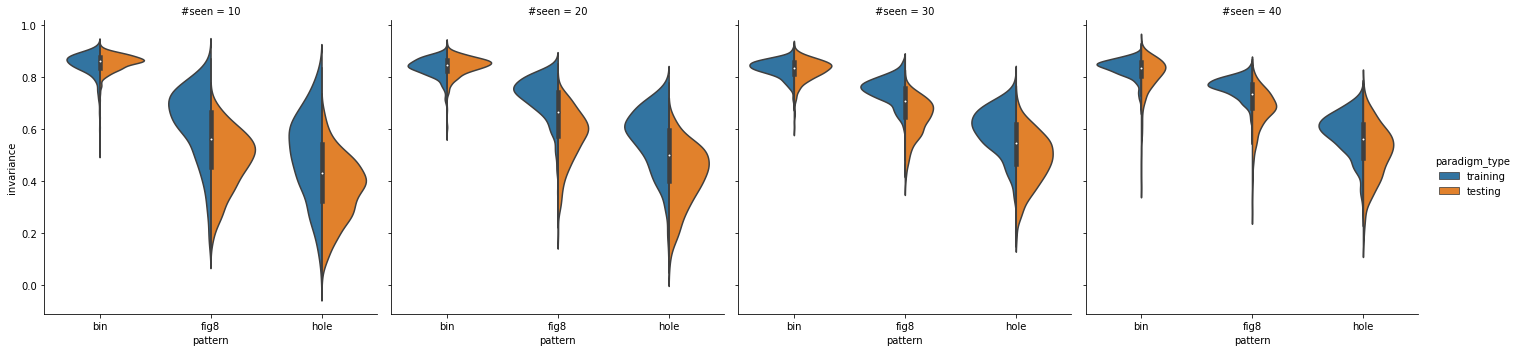

In [17]:
sns.catplot(kind='violin', data=violin_data, col='#seen', x='pattern', y='invariance', split=True, hue='paradigm_type', hue_order=['training', 'testing'])

In [ ]:
sns.scatterplot(data=corr_data, x='invariance', y='correct', hue='pattern', size='#seen')

In [ ]:
e = ExpData.get_experiments(3)

image_activations = np.load(e.image_activations)

rd = RotationDataset(e)
df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes

in_bin = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
df['in_bin'] = in_bin
in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
in_fig8 = ~in_bin & ~in_hole

df['paradigm_type'] = df.model_name.isin(rd.training_models).apply(lambda x: ['testing', 'training'][x])
df['pattern'] = (in_bin + (in_hole * 2) + (in_fig8 * 3)).apply(lambda x: ['none', 'bin', 'hole', 'fig8'][x])

norm_image_activations = image_activations / np.max(image_activations, axis=0)

THRESHOLD = 0.2

pre_transformed_activations = np.zeros((50, 512))
for name, group in df[df.in_bin].groupby('model_name'):
    pre_transformed_activations[group.model_code.iloc[0]] = np.mean(norm_image_activations[group.index], axis=0)

pre_transformed_activations_per_image = pre_transformed_activations[df.model_code]

image_invariances = 1 - np.abs((norm_image_activations - pre_transformed_activations_per_image) / (norm_image_activations + pre_transformed_activations_per_image))

image_invariances_thresholded = np.where((norm_image_activations > THRESHOLD) | (pre_transformed_activations_per_image > THRESHOLD), image_invariances, np.nan)

data = df.groupby(['paradigm_type', 'pattern']).apply(lambda group: pd.DataFrame({'invariance':np.nanmean(image_invariances_thresholded[group.index], axis=0)})).reset_index().rename({'level_2': 'neuron'}, axis=1)

In [ ]:
data[data.paradigm_type == 'testing'].groupby('pattern').mean('invariance')

In [ ]:
classic_eval = pd.read_csv(e.eval)
eval_frame = df.merge(right=classic_eval[classic_eval.epoch == max(classic_eval.epoch)], left_on='image_name', right_on='image_name')
eval_frame.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)

l = eval_frame.groupby('pattern').mean('correct')

r = data[data.paradigm_type == 'testing'].groupby('pattern').mean('invariance')

l.merge(r, left_index=True, right_index=True)

In [ ]:
eval_frame.melt(id_vars=['bin', 'hole', 'fig8'], value_vars='correct')

In [ ]:
np.mean(eval_frame[eval_frame.hole].correct)

In [ ]:
def fs(x):
    return set(np.argwhere(x).flatten())

e = ExpData.get_experiments(3)
image_activations = np.load(e.image_activations)
rd = RotationDataset(e)
df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes
norm_image_activations = image_activations / np.max(image_activations, axis=0)
in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
df['in_bin'] = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
df['in_hole'] = in_hole

neural_cat_activations = np.zeros((3, 50, 512))
for name, group in df.groupby('model_name'):
    neural_cat_activations[0, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[group.in_bin].index], axis=0)
    neural_cat_activations[1, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & ~group.in_hole].index], axis=0)
    neural_cat_activations[2, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & group.in_hole].index], axis=0)

neural_cat_activations = neural_cat_activations.reshape(150, 512)
norm_activity = neural_cat_activations / np.max(neural_cat_activations, axis=0)

selectivity = norm_activity > 0.8
selectivity = selectivity.reshape(3, 50, 512)

f = np.any(selectivity[:,:40], axis=1)
r = np.any(selectivity[:,40:], axis=1)

fb, f8, fh = [x for x in f]
rb, r8, rh = [x for x in r]

In [ ]:
combs = []
for x in range(1, 16):
    b_rep = bin(x)[2:]
    combs.append([int(y) for y in '0' * (4 - len(b_rep)) + b_rep])
combs = np.array(combs, dtype=bool)

In [ ]:
groups = np.array([fb, rb, f8, r8])
labels = ['fb', 'rb', 'f8', 'r8']

In [ ]:
headers = []
for comb in combs:
    header = []
    for i, c in enumerate(comb):
        if c:
            header.append(labels[i])
    headers.append(', '.join(header))

In [ ]:
venn_intersections = ~(np.expand_dims(groups, 0) ^ np.expand_dims(combs, 2))

In [ ]:
counts = np.sum(np.all(venn_intersections, axis=1), axis=1)

In [ ]:
ratios = np.round((counts * 100) / np.sum(counts), 2)

In [ ]:
pd.DataFrame({'count': counts, 'ratio': ratios}, index=headers)

In [ ]:
pd.DataFrame({k:v for k, v in zip(headers, counts)}, index=[0])

In [18]:
def fs(x):
    return set(np.argwhere(x).flatten())

results = []

for x in range(4):
    e = ExpData.get_experiments(x)
    image_activations = np.load(e.image_activations)
    rd = RotationDataset(e)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes
    norm_image_activations = image_activations / np.max(image_activations, axis=0)
    in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
    df['in_bin'] = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
    df['in_hole'] = in_hole
    
    fc_weights = torch.load(e.checkpoint, map_location=torch.device('cpu'))['fc.weight'].detach().cpu().numpy()

    neural_cat_activations = np.zeros((3, 50, 512))
    for name, group in df.groupby('model_name'):
        neural_cat_activations[0, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[group.in_bin].index], axis=0)
        neural_cat_activations[1, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & ~group.in_hole].index], axis=0)
        neural_cat_activations[2, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & group.in_hole].index], axis=0)

    # neural_cat_activations = np.expand_dims(fc_weights, 0) * neural_cat_activations
    neural_cat_activations = neural_cat_activations.reshape(150, 512)
    norm_activity = neural_cat_activations / np.max(neural_cat_activations, axis=0)

    selectivity = norm_activity > 0.8
    selectivity = selectivity.reshape(3, 50, 512)

    f = np.any(selectivity[:,:40], axis=1)
    r = np.any(selectivity[:,40:], axis=1)

    fb, f8, fh = f
    rb, r8, rh = r

    b = fs(f[0] | r[0])
    fig8 = fs(f[1] | r[1])
    h = fs(f[2] | r[2])

    results.append({'fb':fb, 'f8':f8, 'fh':fh, 'rb':rb, 'r8':r8, 'rh':rh, 'b':b, 'fig8':fig8, 'h':h})

In [19]:
diagrams = [
    (['fb', 'rb', 'f8', 'r8']),
    (['fb', 'rb', 'fh', 'rh']),
]

In [21]:
counts = np.zeros((4, 15))
ratios = np.zeros((4, 15))
for x in range(4):
    groups = np.array([results[x][g] for g in diagrams[0]])
    labels = diagrams[0]
    venn_intersections = ~(np.expand_dims(groups, 0) ^ np.expand_dims(combs, 2))
    counts[x] = np.sum(np.all(venn_intersections, axis=1), axis=1)
    ratios[x] = np.round((counts[x] * 100) / np.sum(counts[x]), 2)

NameError: name 'combs' is not defined

In [ ]:
counts

In [ ]:
counts.T.flatten()

In [ ]:
nested_dicts = [{f'counts #{(d + 1) * 10}': counts[d], f'ratios #{(d + 1) * 10}': ratios[d]} for d in range(4)]
flattened_dicts = {k: v for d in nested_dicts for k, v in d.items()}

In [ ]:
idx = pd.MultiIndex.from_product([headers,
                                  [(x + 1) * 10 for x in range(4)]],
                                 names=['group', '# seen'])

In [ ]:
pd.DataFrame({'counts': counts.T.flatten(), 'ratios': ratios.T.flatten()}, index=idx, columns=['counts', 'ratios'])

In [ ]:
diagrams = [
    (['fb', 'f8', 'fh'], 'fully seen venn'),
    (['rb', 'r8', 'rh'], 'restricted seen venn'),
    (['b', 'f8', 'r8'], 'bin fig8 crossover'),
    (['b', 'fh', 'rh'], 'bin fig8 crossover'),
]
def set_venn_scale(ax, true_area, reference_area=300):
    s = np.sqrt(float(reference_area)/true_area)
    ax.set_xlim(-s, s)
    ax.set_ylim(-s, s)

In [42]:
venn2([set(np.argwhere(results[0][fb])), set(np.argwhere(results[0][f8]))])

TypeError: unhashable type: 'numpy.ndarray'

TypeError: bad operand type for abs(): 'set'

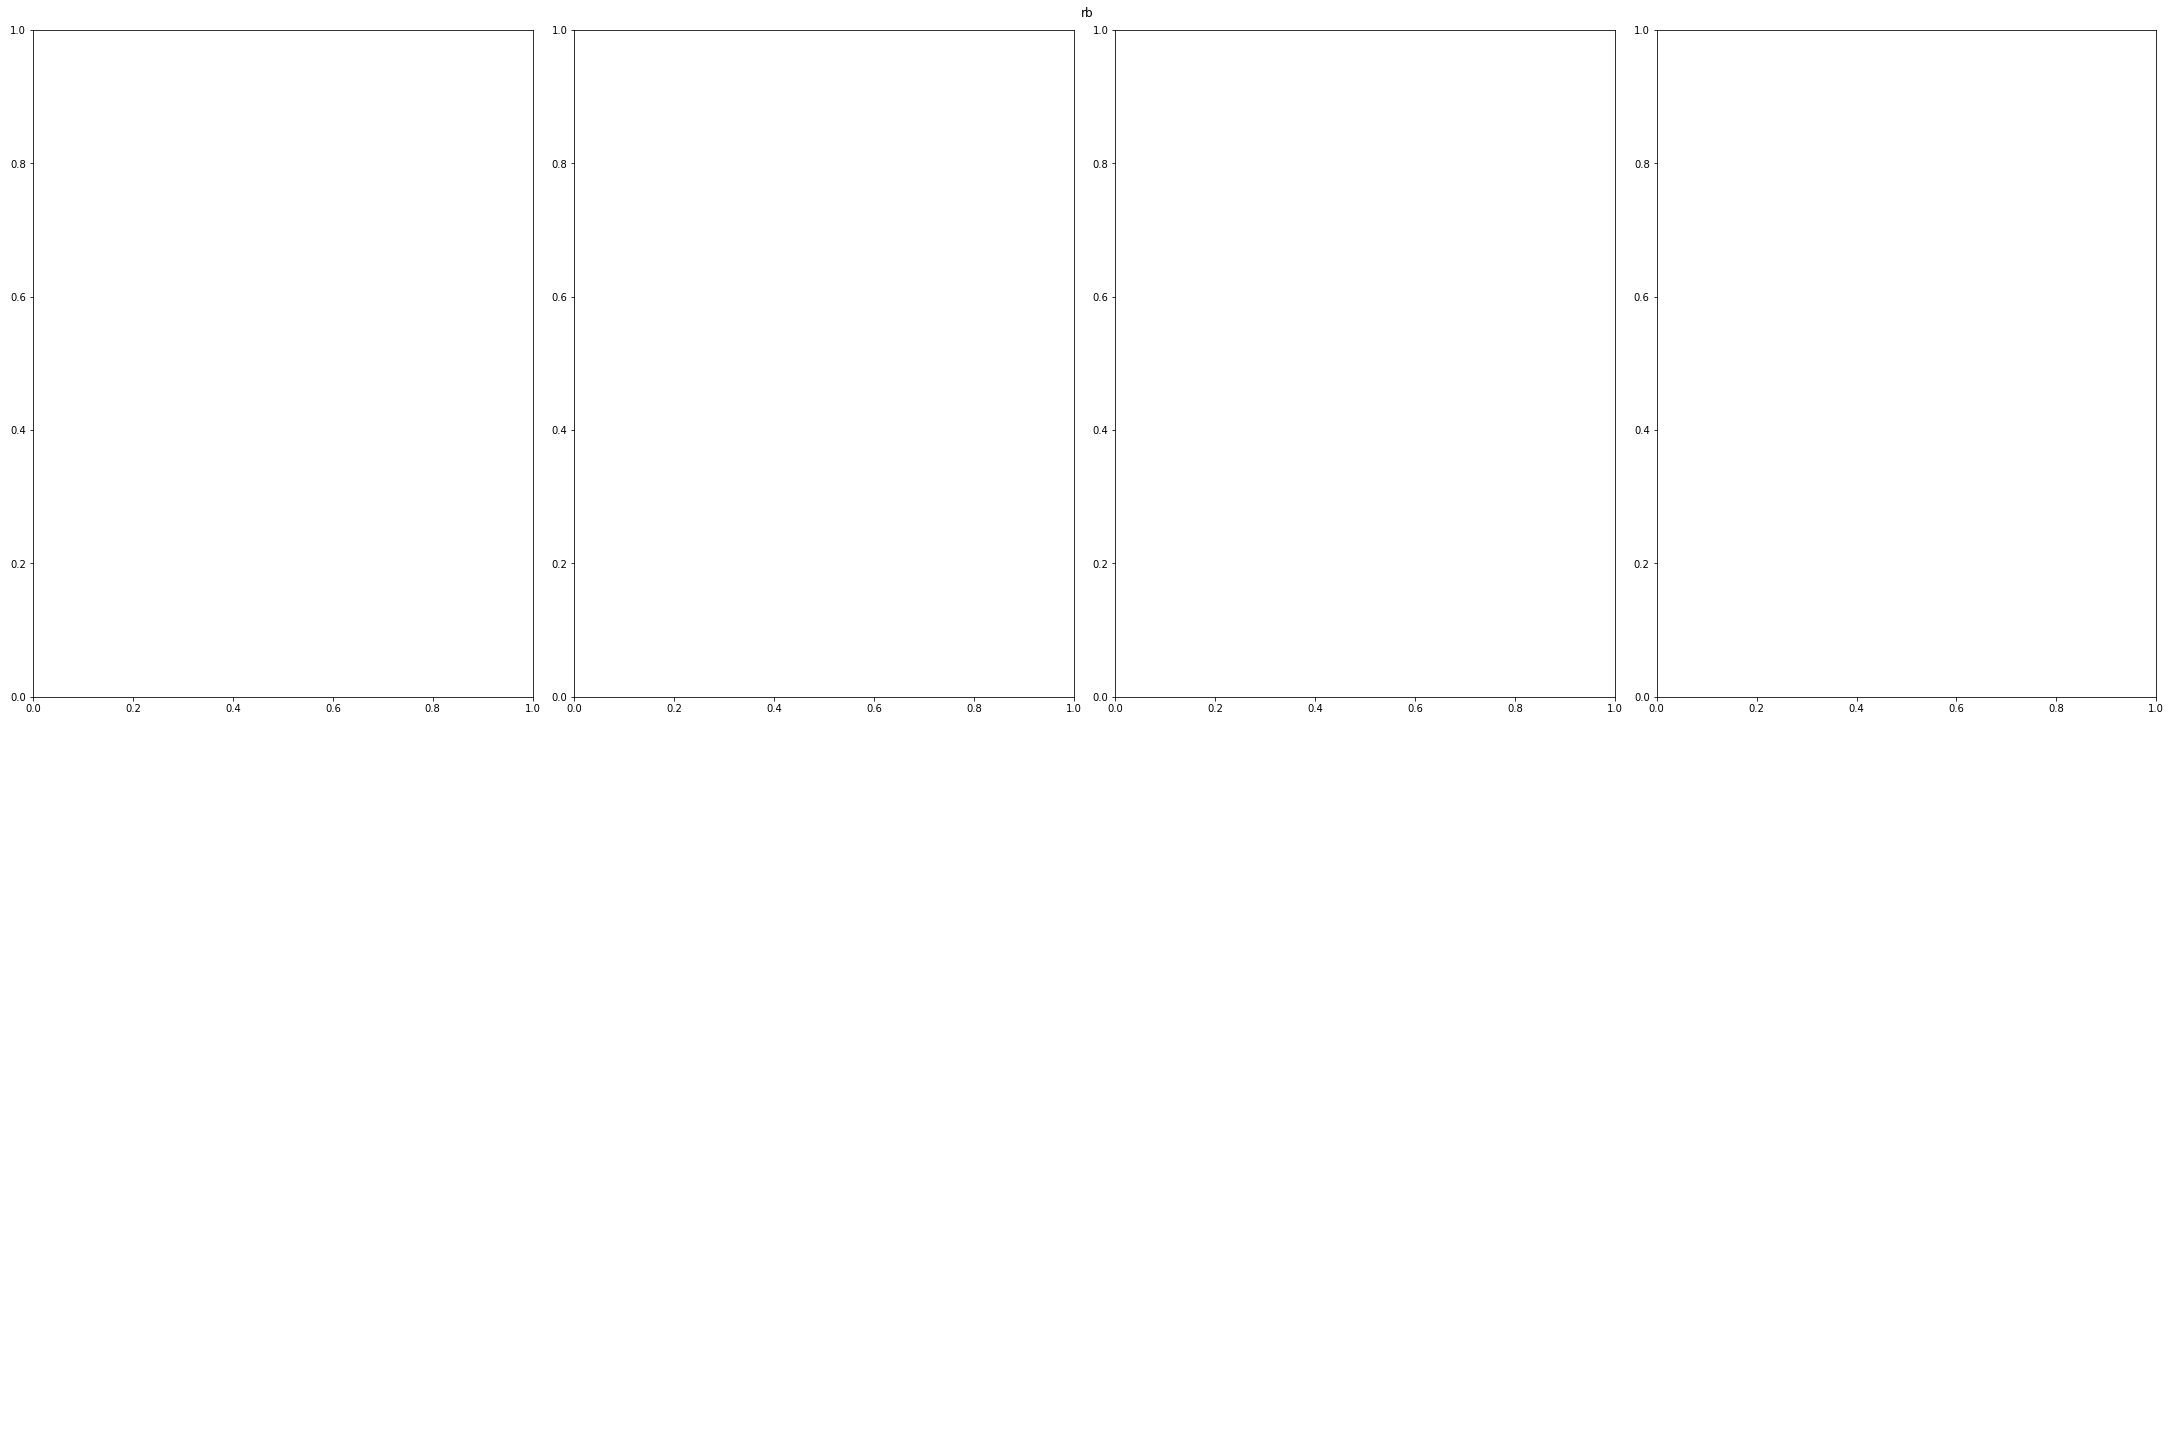

In [45]:
plt.close('all')

fig = plt.figure(constrained_layout=True, figsize=(30, 20))

subfigs = fig.subfigures(nrows=len(diagrams), ncols=1)
for subfig, diagram in zip(subfigs, diagrams):
    subfig.suptitle(diagram[1])

    axes = subfig.subplots(1, 4)

    for x in range(4):
        venn3([set(np.argwhere(results[x][g]).flatten()) for g in diagrams[0]], set_labels=[g for g in diagrams[0]], ax=axes[x])
        axes[x].set(title=f'#seen: {(x + 1) * 10}')
        # from matplotlib_venn._venn3 import compute_venn3_subsets
        # set_venn_scale(axes[x], sum(compute_venn3_subsets(*[results[x][g] for g in diagrams[0][0]])))

In [ ]:
plt.close('all')

fig = plt.figure(constrained_layout=True, figsize=(30, 10))

subfigs = fig.subfigures(nrows=len(diagrams), ncols=1)
for subfig, diagram in zip(subfigs, diagrams):
    subfig.suptitle(diagram[1])

    axes = subfig.subplots(1, 4)

    for x in range(4):
        venn3([results[x][g] for g in diagram[0]], set_labels=[g for g in diagram[0]], ax=axes[x])
        axes[x].set(title=f'#seen: {(x + 1) * 10}')
        # from matplotlib_venn._venn3 import compute_venn3_subsets
        # set_venn_scale(axes[x], sum(compute_venn3_subsets(*[results[x][g] for g in diagrams[0][0]])))

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

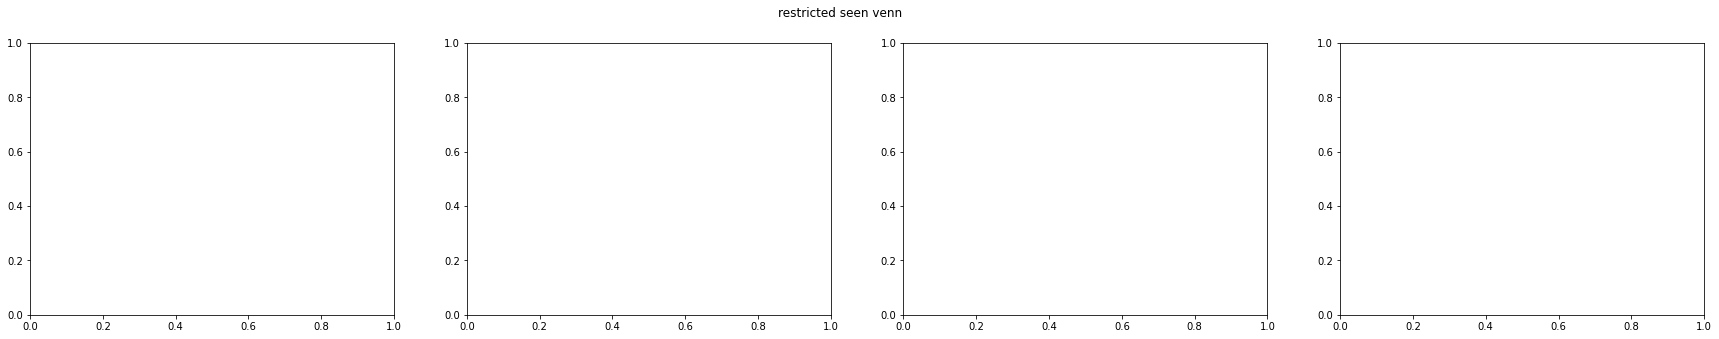

In [22]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('restricted seen venn')
for x in range(4):
    res = results[x]
    venn3([res['rb'], res['r8'], res['rh']], set_labels=['r_bin', 'r_fig8', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')
    
for a, d in zip(flatten(axes), range(4)):
    print(sum(compute_venn3_subsets(*[results[d][g] for g in diagrams[1][0]])))
    set_venn_scale(a, sum(compute_venn3_subsets(*[results[d][g] for g in diagrams[1][0]])))
    
plt.show()

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('restricted seen venn')
for x in range(4):
    res = results[x]
    venn3([res['rb'], res['r8'], res['rh']], set_labels=['r_bin', 'r_fig8', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')
    
for a, d in zip(flatten(axes), range(4)):
    set_venn_scale(a, sum(compute_venn3_subsets(*[results[d][g] for g in diagrams[0][0]])))
    
plt.show()

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('bin crossover')
for x in range(4):
    res = results[x]
    venn2([res['fb'], res['rb']], set_labels=['f_bin', 'r_bin'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('8 crossover')
for x in range(4):
    res = results[x]
    venn2([res['f8'], res['r8']], set_labels=['f_fig8', 'r_fig8'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('hole crossover')
for x in range(4):
    res = results[x]
    venn2([res['fh'], res['rh']], set_labels=['f_hole', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('bin fig8 crossover')
for x in range(4):
    res = results[x]
    venn3([res['b'], res['f8'], res['r8']], set_labels=['f+r_bin', 'f_fig8', 'r_fig8'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('bin hole crossover')
for x in range(4):
    res = results[x]
    venn3([res['b'], res['fh'], res['rh']], set_labels=['f+r_bin', 'f_hole', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
all_data = None
for x in range(4):
    e = ExpData.get_experiments(x)
    image_activations = np.load(e.image_activations)
    rd = RotationDataset(e)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes
    norm_image_activations = image_activations / np.max(image_activations, axis=0)
    in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
    df['in_bin'] = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
    df['in_hole'] = in_hole

    neural_cat_activations = np.zeros((3, 50, 512))
    for name, group in df.groupby('model_name'):
        neural_cat_activations[0, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[group.in_bin].index], axis=0)
        neural_cat_activations[1, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & ~group.in_hole].index], axis=0)
        neural_cat_activations[2, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & group.in_hole].index], axis=0)

    norm_activity = normalize(neural_cat_activations.reshape(150, 512), axis=0, norm='l1')

    selectivity = np.zeros((150, 512))
    for y in range(512):
        a = norm_activity[:, y]
        b = np.argsort(a)[::-1]
        c = np.add.accumulate(a[b]) < 0.2
        selectivity[b[c], y] = 1
    
    selectivity = selectivity.reshape(3, 50, 512)

    f = np.any(selectivity[:,:40], axis=1)
    r = np.any(selectivity[:,:40], axis=1)

    fb = f[0]
    f8 = f[1]
    fh = f[2]

    rb = r[0]
    r8 = r[1]
    rh = r[2]

    data = pd.DataFrame({
        'bf': fb & ~f8 & ~fh & ~rb & ~r8 & ~rh,
        '8f': ~fb & f8 & ~fh & ~rb & ~r8 & ~rh,
        'hf': ~fb & ~f8 & fh & ~rb & ~r8 & ~rh,
        'b8f': fb & f8 & ~fh & ~rb & ~r8 & ~rh,
        'bhf': fb & ~f8 & fh & ~rb & ~r8 & ~rh,
        'b8hf': fb & f8 & fh & ~rb & ~r8 & ~rh,
        'br': ~fb & ~f8 & ~fh & rb & ~r8 & ~rh,
        '8r': ~fb & ~f8 & ~fh & ~rb & r8 & ~rh,
        'hr': ~fb & ~f8 & ~fh & ~rb & ~r8 & rh,
        'b8r': ~fb & ~f8 & ~fh & rb & r8 & ~rh,
        'bhr': ~fb & ~f8 & ~fh & rb & ~r8 & rh,
        'b8hr': ~fb & ~f8 & ~fh & rb & r8 & rh,
        'bfr': fb & ~f8 & ~fh & rb & ~r8 & ~rh,
        '8fr': ~fb & f8 & ~fh & ~rb & r8 & ~rh,
        'hfr': ~fb & ~f8 & fh & ~rb & ~r8 & rh,
        'b8fr': fb & f8 & ~fh & rb & r8 & ~rh,
        'bhfr': fb & ~f8 & fh & rb & ~r8 & rh,
        'bh8fr': fb & f8 & fh & rb & r8 & rh,
    })
    
    melted_data = data.melt()
    melted_data = melted_data[melted_data.value]
    
    melted_data['#seen'] = e.data_div
    if all_data is None:
        all_data = melted_data
    else:
        all_data = all_data.append(melted_data)
    print(f'done {x}')

In [ ]:
sns.catplot(kind='count', col='#seen', x='variable', data=all_data, col_wrap=2)